# Slot Evaluation and Reporting

Author: [@abhinav](https://lepisma.xyz/)

Document for working on the slot evaluation problem in spoken dialog systems. The aim is to onboard everyone on various details of scoring slots and coming up with a standardized process for reporting and talking about performance.

Here is the agenda:

1. Differences between slots and entities
1. Standard slot-filling metrics
1. Issues with just Precision and Recall
1. MM, MF, NF
1. What to report?
1. How to report?
1. Action items

## 1. Slots and Entities

At the moment we use the common intent-slot formulation to _understand_ utterances. An utterance here has the [regular meaning](https://en.wikipedia.org/wiki/Utterance) and going from an utterance to semantic parses might or might not involve ASR intermediates. In the intent-slot formulation, a **slot** maps to a semantic unit that works like an attribute for the intent. For example `arrival_city` is a slot that might be associated with `flight_booking` intent.

A **slot** is a high level construct which, while generalizable, is bound to the use case. Slot can support multiple _type_ of **entities** that are finally _filled_ in the slot (in the factored parsing model, where we first parse entities and then _fill_ slot). For example `arrival_city` can support a type `city`. When we parse a `city` entity from an utterance, we can, if appropriate, fill `arrival_city` with that value.

Since they are mostly portable set of tokens, **entities** are usually, not always, identifiable via a span in text. Here is one of the span parser's output which provides the span description as substring _range_:

```python
text = "Sunday morning love you"

entity = {
    "body": "Sunday morning",
    "range": {
        "start": 0,
        "end": 14
    },
    "score": None,
    "value": ...,
    "type": "datetime"
}
```

Our current way of working with ASR involves using n-best alternatives for each utterance. This means any span based entity parser also has to locate the span among the alternatives and that should show up in the final structure.

There are many reasons why entities and slots should be looked at separately. While you can always _level up_ an entity, we try to keep entities at a syntactic level and slots at semantic level. This means that entities cover what the user _said_, slots cover what the user _meant_. Here are a few concerns that can help understand the differences better:

1. N-best noise
2. Speech disfluencies
3. Type disambiguation
4. Filling operators
5. Repairs and multi turn recovery


### 1.1. N-best noise

The user has uttered something but the ASR's noise, represented in the n-best list, is making it hard to understand what the user _said_. Here is an example where the user actually said `7 pm`:

```python
alternatives = [[
    {"transcript": "i was born at 7 pm"},
    {"transcript": "i was born at 11 pm"},
    {"transcript": "i was born at seven pm"}
]]
```

This is a problem at entity parser level. While the slot could also be equivalent to entity in this case, this won't always be true.


### 1.2. Speech disfluencies

Now consider disfluencies like repetitions and repairs. Suppose a person said `3 pm, no no, 5 pm` in response to a retaurant booking time query. In this case, it's okay, if designed, for a time entity parser to capture `3 pm` and `5 pm`. But the slot `booking_time` should capture `5 pm`. We tend to merge parsing for this, but it's a distinction to be aware of.


### 1.3. Type disambiguation

At times you might have two slots with same entity type. When the entity is captured, you will have to decide which slot it fits in. Usually this is not a problem across turns, but you might get this issue if the same turn contains both entities. Here is an example utterance from flight booking: "Bangalore to Delhi". There are two slots here, `arrival_city` and `departure_city`. Both might support entity type `city`. While parsing the above mentioned sentence, we can use standard `city` parser but will need another system to do disambiguation at slot level. You can also make an entity of type `arrival_city` but that will cost in units of transferability.


### 1.4. Slot filling operators

Entities, by definition don't come with a contextual defintion. For example in `not 3 pm`, `3 pm` can be parsed as an entity and no one will be hurt. But if you add the context of `not`, you will realize that the slot, say, `booking_time` should _not_ be filled with this value.

This points to the idea of semantic operators for slot filling. In this case, the operator was `not`. We could represent parsing _with operators_ like the following syntax tree (adding few more operators):

| Sentence | Parse | Name | Remarks |
|----------|-------|-----|-------|
| I want 3 pm | `{"op": None, "args": [<3 pm>]}` | _ | Regular Single Parse |
| I want at <probably 3 pm> | `{"op": "maybe", "args": [<3 pm>, "medium"]}` | Bot Confusion | Second argument is strength of confidence |
| I don't want at 3 pm | `{"op": "not", "args": [<3 pm>]}` | Negation | Note that "3 pm" will be represented in entity format |
| Book at 4 pm or 9 pm | `{"op": "any", "args": [<4 pm>, <9 pm>]}` | Disjunction | User wants to convey and OR-ness of preference |
| I want 3 pm and 6 pm | `{"op": "and", "args": [<3 pm>, <6 pm>]}` | Conjunction | User wants bookings in _both_ slots. This also shows up in intent as multiple intent parsing problem. Note that two _different_ slots being parsed from same utterance is a different problem. For example parsing `booking_time` and `booking_location`, irrespective of their constituent types. |
| I want <probably 3 pm or 4 pm> | `{"op": "one-of", "args": [<3 pm>, <4 pm>]}` | Bot Confusion (multi) |  User wants to book at one time, but our model got confused between two. This is to convey that confusion. Implementation wise, this could be based on confidence values that are similar. |
| I want to do \<this entity> then \<that entity> | `{"op": "seq", "args": [<this entity>, <that entity>]}` | Sequencing two or more slot values | Mostly useful for intents, but can also be helpful in slots. |

Note that these operators could compose also. For example, you might get a `not` over an `and`. But a lot of complications are extremely rare. Be mindful when implementing systems for these.

The above schema is just suggestive. If you want to track work on it, use the name `SLU API v2` and talk to @platform-ml team.


### 1.5. Repairs and multi turn recovery

Going beyond turns and covering dialog level strategies (like skiplisting), we realize that multi turn slot capture is a thing (and not entity). This would mean even with poor slot capture performance, we _might_ get to better eventual performance.


Note that in all the examples above we could have gone ahead without intermediate entity parsing step but practically that's not a good decision since we already have many low level entity parsers that are transferrable.

## 2. Standard slot-filling metrics

The academic standard is to take slots tagged in BIO format (read [this](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) to know more) and do span matches to get precision, recall, and f1. Here is the structure from the famous [conlleval](https://github.com/sighsmile/conlleval) script:


```
   Boeing NNP B-NP I-NP
   's POS B-NP B-NP
   747 CD I-NP I-NP
   jetliners NNS I-NP I-NP
   . . O O
   
   Rockwell NNP B-NP I-NP
   said VBD B-VP B-VP
   the DT B-NP B-NP
   agreement NN I-NP I-NP
```

When you run the script, you get per `class` numbers:

```
   processed 961 tokens with 459 phrases; found: 539 phrases; correct: 371.
   accuracy:  84.08%; precision:  68.83%; recall:  80.83%; FB1:  74.35
                ADJP: precision:   0.00%; recall:   0.00%; FB1:   0.00
                ADVP: precision:  45.45%; recall:  62.50%; FB1:  52.63
                  NP: precision:  64.98%; recall:  78.63%; FB1:  71.16
                  PP: precision:  83.18%; recall:  98.89%; FB1:  90.36
                SBAR: precision:  66.67%; recall:  33.33%; FB1:  44.44
                  VP: precision:  69.00%; recall:  79.31%; FB1:  73.80
```

Think a little about this and see why this is not sufficient for us. There are two sides to the argument, one from ASR to text, other from text to structured parse.

## 3. Issues with just Precision and Recall

Here is the definition of precision and recall (you can derive f1 from this):

$$
\begin{aligned}
\text{precision} &= \frac{tp}{tp + fp} \\
\text{recall} &= \frac{tp}{tp + fn}
\end{aligned}
$$

Now consider each case one by one:


|    | Truth | Prediction |
|-----|-------|------------|
|  tp | $x$   | $x$ |
|  fp | $\phi$ | $x$ |
|  tn | $\phi$ | $\phi$ |
|  fn | $x$   | $\phi$ |


What if the truth is $x$ but the prediction is $y$ and not $\phi$? This implies there is a presence of an equality function that works on non-null values and tells if they are equal. Implicitly, the `conlleval` setup uses a function that exact matches `(span, class)`.

If the `class` is fixed then per `class` F1, precision, and recall work fine. But in our case, where BIO tagging gets hits from both sides—transcription noise and parsing failures—deliberately designed equality function takes the center stage. You can always parametrize the classses but that doesn't work for open sets. You might also notice that the 4 values now don't sum to 100% unless you redefine `class` by breaking open value of entities, but that would mean that `7 pm` and `11 pm` are different classes.

## 4. MM, MF, NF

Here is a more useful table, extending the previous one:


|    | Truth | Prediction |
|-----|-------|------------|
|  tp | $x\|y$   | $x\|y$ |
|  tp[$\ne$] | $x\|y$ | $y\|x$ |
|  fp | $\phi$ | $x\|y$ |
|  tn | $\phi$ | $\phi$ |
|  fn | $x\|y$   | $\phi$ |


Metrics should be helpful in deciding what to do next. Given our context, we found misfires, mismatches, and nofires to be useful. High misfires tells that the ASR or parsers are too trigger happy. High nofires tells that we are missing too much and might need to check if rules or lexicons are lacking. High mismatches tells us, mostly, that we are not able to deal with transcription noise well in parsing. Here are the definitions:

$$
\begin{aligned}
\text{misfires (fpr)} &= \frac{fp}{fp + tn} \\
\text{mismatches} &= \frac{tp[\ne]}{tp + tp[\ne]} \\
\text{nofires (fnr)} &= \frac{fn}{tp + tp[\ne] + fn}
\end{aligned}
$$

Note that mismatches' definition has changed from its last usage.

Since we have been using the previous terminologies for a while, I used them to explain here. But going forwards, let's start using the standard terminologies known in the field. This means the following changes going forward:

1. _Misfires_ becomes False Positive Rate (FPR) or Fall-Out
1. _Nofires_ becomes False Negative Rate (FNR) or Miss Rate
1. _Mismatches_ becomes Mismatch Rate

Read more [here](https://en.wikipedia.org/wiki/Precision_and_recall).

## 5. What to Report?

We would want a single metric that tells the general state of the specific **slot** parser (entity reporting is internal and can be done with the same tool and processes) while keeping the internal breakdown as previously described.

We can try accuracy as the single metric. This would be the following:

$$\text{accuracy} = \frac{tp + tn}{tp + tp[\ne] + fp + tn + fn}$$

But this is very non robust and isn't going to be standard across flows since $tn$ will change drastically based on the flow. The impact of $tn$ makes $\text{fpr}$ also non standard and useless. Remember, one slot usually comes in action only during a brief period of the whole conversation.

A good single metric that also covers a missing aspect is **Slot Capture Rate (SCR)** (_new nomenclature_). SCR goes across  turns and tells if at the end of the call (whether dropoff or transferred or resolved) the slot value filled was correct or not. Minimum criteria for counting a call here is to ensure that the user provided the slot value in any turn, with or without bot's initiation.

SCR can be estimated fairly well by tracking FSMs state and using slot tagged data. Similar to intents, we can also come up with sub-flow where the slot was being pursued and define **Slot Retry Rate** as a metric tracking user annoyance. For debugging purposes and developing dialog level strategies, we will also be interested in the `@k` class of metrics which makes sense only for Mismatch Rate.

Finally, here is the recommendation for reporting, all based on utterance tagging:

- Top level
  1. SCR
  1. Slot Retry Rate
- Turn level
  1. FPR
  1. FNR
  1. Mismatch Rate
- Misc
  1. Mismatch Rate@k

## 6. How to Report?

Reporting involves deciding which datapoints to tag, how to tag, and finally how to get the above metrics. All of these are covered in this section.

### 6.1. Sampling

The first step is of sampling. Here we decide which dialogs and turns to pick for annotation. In an ideal situation, we should be taking a uniform sample of calls and annotate all turns of each call. While this is the suggested way, we have seen people using samples where only turns relevant to a slot are picked and tagged for efficiency reasons. This is alright, but we need to be aware of the following:

1. Few metrics might lose reliability and stop being comparable. For example, if you only pick turns where the bot asks question about a slot to the user, your FPR will become useless.
1. Sampling turns with biases will require an unbiasing before reporting numbers. For example, consider you are taking two kinds of turns. The first kind has involvement with the slot in question but only makes up 10% of the overall turns. To increase efficiency you might have sampled in a way where your dataset has 80% of the first kind turns. In this case, while reporting numbers, you will want to downweigh the first kind and upweigh the second to represent the true 10%-90% distribution.

While you can still cheat there, the Top level metrics like SCR and Slot Retry Rate will need full calls and you won't be able to sample turns _within_ a call.

Bottomline, just take random sample of calls and tag everything for now.


### 6.2. Annotation

At the very top level, the annotations are going to be from utterances to slots. No ranges, no ASR dependencies. This is sufficient to compute the metrics we want to report.

However, for training models you might spend more time here. For example you might mark spans for entities in the ASR n-best list as done in text based NER annotation like below.

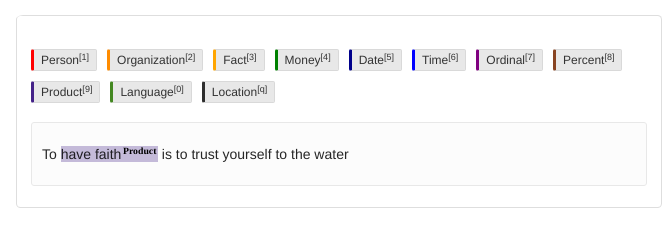

This can be then used for training and tuning ranged parsers, *except that the spans will go stale the moment you change anything in the ASR*.

Another concern in annotation is about representing the tag value. Since slots can have multiple types, the annotation tool can't catch up with the ability to quickly annotate a new type. For example, in tog we don't allow a datetime picker for annotating datetime. Rather we let the annotators pick (or enter if ASR is not returning anything relevant) text and generate tagged _value_ later on during dataset usage. So if today (14th May, 2021) we have a datapoint with the following alternatives,

```python
alternative = [[
    {"transcript": "i want to go tomorrow morning"},
    {"transcript": "i want to go morning"},
    {"transcript": "i want to go to morning"}
]]
```

we will let the annotator provide "tomorrow morning" (assuming that's what the user really said) as the tag and while processing the data, will convert it to `(datetime(2021, 5, 15, 9), datetime(2021, 5,  15, 12))` using a dedicated parser.

Many of these problems' solutions have been attempted in tog workflows and it's instructive to study the outcomes there.


### 6.3. Reporting


Once we have the annotated data (no need of spans), we can run a standard script to produce the final performance report.

## 7. Action items

TODO: Run live

- Who owns the process?
- Who builds the tools?